#  Transformer Architecture

In [3]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial6"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


/tmp/ipykernel_15455/2396732740.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

## Purpose of Matrices $W_q$, $W_k$, and $W_v$ in

In the Transformer architecture, the matrices $W_q$, $W_k$, and $W_v$ are learned weight matrices that are used to transform the input embeddings into three different vector spaces: queries, keys, and values. These transformations are central to the self-attention mechanism, which is the core component of the Transformer model.

### 1. Matrix $W_q$ (Query Weight Matrix)

Purpose: The query weight matrix $W_q$ transforms the input embeddings (or the output of the previous layer) into a set of query vectors.

Function: Each query vector represents the information that a particular word (or token) in the input sequence is trying to obtain from the other words in the sequence.

Operation: Given an input vector $x$, the query vector $q$ is computed as $q = xW_q$. This transformation projects the input into the "query space", which is specifically designed for computing similarities with keys.

### 2. Matrix $W_k$ (Key Weight Matrix)

Purpose: The key weight matrix $W_k$ transforms the input embeddings into a set of key vectors.

Function: Each key vector represents the features or the characteristics of each word in the sequence that can be attended to. Essentially, it acts like a set of indicators for what each word has to offer.

Operation: Given an input vector $x$, the key vector $k$ is computed as $k = xW_k$. This transformation projects the input into the "key space", where it can be compared against the queries.

### 3. Matrix $W_v$ (Value Weight Matrix)

Purpose: The value weight matrix $W_v$ transforms the input embeddings into a set of value vectors.

Function: Each value vector contains the actual information of the words, which will be aggregated (weighted by the attention scores) to form the final output of the self-attention mechanism.

Operation: Given an input vector $x$, the value vector $v$ is computed as $v = xW_v$. This transformation projects the input into the "value space", which holds the content that will be attended to.

### Self-Attention Mechanism

During the self-attention process, these three matrices are used as follows:

- Compute Scores: The similarity between the query vector $q$ and the key vector $k$ is computed, typically using a dot product. This gives a score that represents how much focus the model should put on a particular word when encoding or decoding another word.
    $$
    \text{score} = q \cdot k^T
    $$
    
- Scale Scores: These scores are scaled (usually by the square root of the dimension of the key vectors) to stabilize gradients and improve training.
    
  - Softmax: The scaled scores are passed through a softmax function to produce a set of attention weights that sum to 1. These weights determine how much attention each word should receive relative to others in the sequence.
    
   - Weighted Sum: The attention weights are then used to compute a weighted sum of the value vectors $v$. This produces the final output of the self-attention mechanism, where each output vector is a weighted sum of the value vectors, with weights given by the attention scores.
    $$
    \text{output} = \text{softmax}\left(\frac{q \cdot k^T}{\sqrt{d_k}}\right) \cdot v
    $$

### Summary

- $W_q$: Transforms inputs to query vectors — what each word is looking for.
- $W_k$: Transforms inputs to key vectors — what each word represents in terms of being attended to.
- $W_v$: Transforms inputs to value vectors — the actual information or content of each word.

These matrices are crucial in enabling the Transformer to dynamically focus on different parts of the input sequence, capturing complex dependencies and relationships in the data.

# Positional Encodings

In the Transformer model architecture, positional encoding is a technique used to provide information about the position of tokens in a sequence. This is crucial because, unlike traditional recurrent neural networks (RNNs) or convolutional neural networks (CNNs), the Transformer model does not inherently have any sense of order.

Why Positional Encoding is Needed
The Transformer model uses a mechanism called self-attention, which allows it to consider all tokens in a sequence simultaneously, rather than one at a time (as in RNNs). While this makes the Transformer highly efficient and capable of capturing long-range dependencies, it also means that the model lacks a built-in way to understand the sequential order of tokens.

In natural language, the order of words is important because it contributes to the meaning of sentences. For example, the meaning of the sentence "The cat sat on the mat" is different from "The mat sat on the cat," even though they contain the same words. Without positional information, a Transformer would treat these two sentences as if they were the same.

How Positional Encoding Works
To incorporate information about the position of each token, the Transformer adds a positional encoding to the input embeddings. The positional encoding is a vector of the same dimension as the embeddings, and it is added to the input embeddings before being fed into the Transformer layers. This encoding provides a unique representation for each position in the sequence, allowing the model to differentiate between the positions of tokens.

Mathematical Formulation
In the original Transformer paper, "Attention is All You Need," the positional encoding is defined using sine and cosine functions of different frequencies:

$$
\text{PE}_{(pos, 2i)} = \sin \left( \frac{pos}{10000^{\frac{2i}{d}}} \right)
$$

$$
\text{PE}_{(pos, 2i+1)} = \cos \left( \frac{pos}{10000^{\frac{2i}{d}}} \right)
$$

Here:
- $\text{PE}(pos, 2i)$ is the positional encoding for the position $\textit{pos}$ and the even dimension $2i$.
- $\text{PE}(pos, 2i+1)$ is the positional encoding for the position $\textit{pos}$ and the odd dimension $2i+1$.
- $\textit{pos}$ is the position of the word in the sequence.
- $\textit{i}$ is the dimension index.
- $\textit{d}$ is the dimension of the model.


Intuition Behind the Formulas
- Sine and Cosine Functions: The use of sine and cosine functions allows the model to encode positions in a way that is continuous and differentiable, providing smooth transitions for positions and enabling the model to generalize to unseen positions.

- Different Frequencies: By using different frequencies for each dimension, the model can learn relationships between tokens based on their relative positions, as each dimension captures a different aspect of the position in the sequence. Lower dimensions capture longer-range relationships, while higher dimensions capture shorter-range relationships.

- Unique Encoding: The combination of sine and cosine functions ensures that each position has a unique encoding, which helps the model distinguish between different positions in the sequence.

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

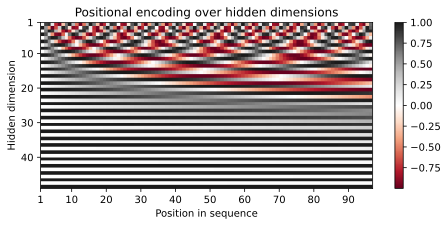

In [5]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

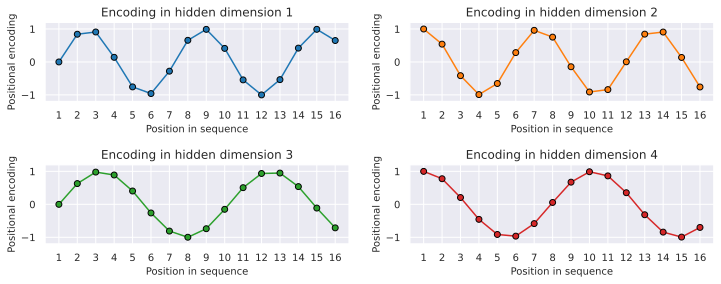

In [10]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()